In [20]:
from time import time
import copy
import math

import torch
import torch_geometric
import GNNTrackingTools as GTT
import models

from torch import optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torch.utils.data import random_split

from torch_geometric.data import Data, DataLoader, InMemoryDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

import sklearn
import inspect



# Load data and setup Graph dataset

In [25]:
tracker_name = 'Recoil'  # Either 'Tagger' or 'Recoil'
n_primaries = 4      # Number of primaries simulated per event

# Read data file
df = pd.read_pickle("/Users/mghrear/data/LDMX_GNN/4e_run1.pkl")

# Compute Info needed to build graphs
# GetGraphInfo requires two arguments: The number of primaries simulated and the tracker name (either 'Tagger' or 'Recoil')
df_graph = pd.DataFrame()
df_graph[['edge_index_0', 'edge_index_1', 'edge_feat_0', 'edge_feat_1', 'edge_feat_2','edge_label']]= df.apply(GTT.GetGraphInfo, axis=1, args=(n_primaries, tracker_name,), result_type='expand')
df_graph['Digi_x'] = df[f'{tracker_name}_Digi_x']
df_graph['Digi_y'] = df[f'{tracker_name}_Digi_y']
df_graph['Digi_z'] = df[f'{tracker_name}_Digi_z']
df_graph['Digi_Edep'] = df[f'{tracker_name}_Digi_Edep']
df_graph['Digi_trackID'] = df[f'{tracker_name}_Digi_trackID']
df_graph['Digi_pdgID'] = df[f'{tracker_name}_Digi_pdgID']


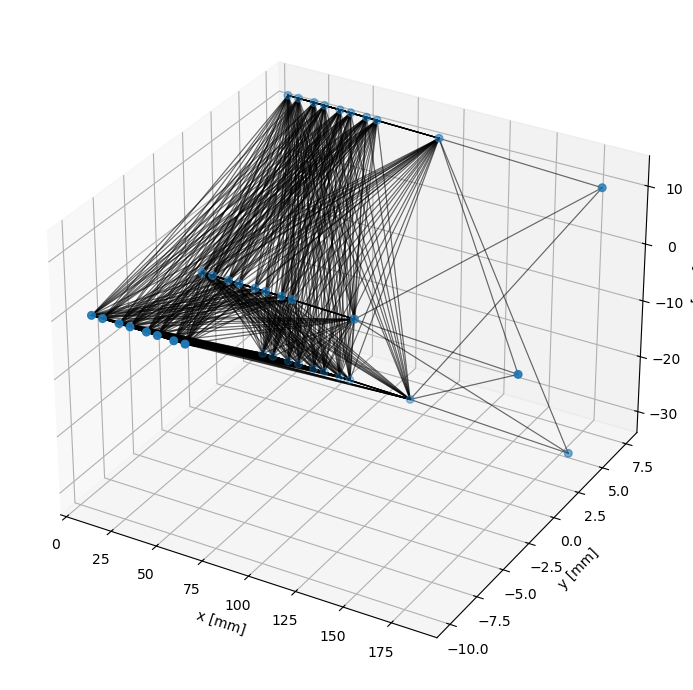

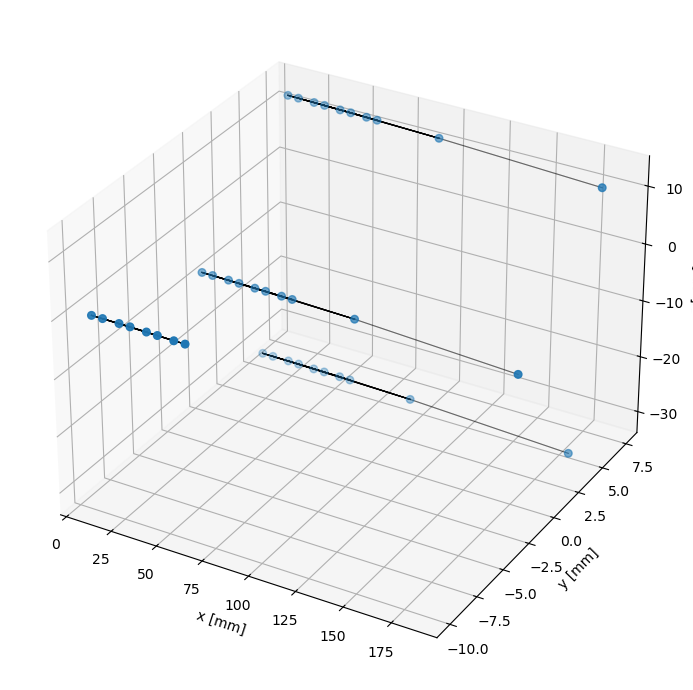

In [26]:
# Make GNN dataset
dataset = GTT.MyInMemoryDataset(df_graph, mode = "EC")

# Plot example graph
data = dataset[2]
GTT.plot_pyg_graph_3d(data, plot_truth=True)

In [27]:
# Split into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7, 0.15, 0.15], generator=torch.Generator().manual_seed(42) )

# Make DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


/var/folders/fx/czrkltw953xcpcjd85tf2tmm0000gn/T/ipykernel_72016/636552133.py:6: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
/var/folders/fx/czrkltw953xcpcjd85tf2tmm0000gn/T/ipykernel_72016/636552133.py:7: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
/var/folders/fx/czrkltw953xcpcjd85tf2tmm0000gn/T/ipykernel_72016/636552133.py:8: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Initialize Model and Optimizer

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [29]:
# Initialize model
hidden_size = 40

model = models.MyIN_Edep(hidden_size).to(device)
total_trainable_params = sum(p.numel() for p in model.parameters())
print(f"Total trainable parameters: {total_trainable_params}")

Total trainable parameters: 18527


In [30]:
# Initialize optimizer

lr = 5E-3
step_size = 5
gamma = 0.9

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

# Train the model

In [31]:
epochs = 100

best_val_loss = math.inf
best_thld = None
best_state_dict = None  # or best_model = None

output = {'train_loss': [], 'val_loss': []}

for epoch in range(1, epochs + 1):
    print(f"---- Epoch {epoch} ----")
    train_loss = GTT.train(model, device, train_loader, optimizer, epoch)
    val_loss = GTT.validate(model, device, val_loader)

    # keep best model (lowest val loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state_dict = copy.deepcopy(model.state_dict()) 

    scheduler.step()

    output['train_loss'].append(train_loss)
    output['val_loss'].append(val_loss)


---- Epoch 1 ----
...epoch time: 23.600908994674683s
...epoch 1: train loss=0.26102181958844234
...val loss= 0.11357591993791956
---- Epoch 2 ----
...epoch time: 22.028353214263916s
...epoch 2: train loss=0.058612451495144144
...val loss= 0.04849236141103254
---- Epoch 3 ----


KeyboardInterrupt: 

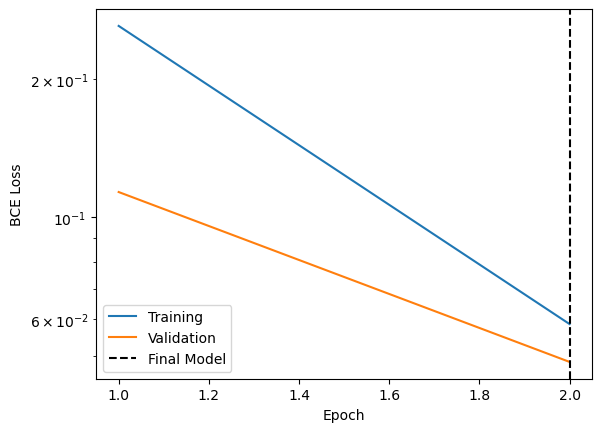

In [32]:
# convert output to pandas DataFrame 
output_df = pd.DataFrame(output)

# Plot the training and validation losses
plt.plot(np.arange(len(output_df))+1,output_df.train_loss,label='Training')
plt.plot(np.arange(len(output_df))+1,output_df.val_loss,label='Validation')
plt.axvline(x=np.argmin(output_df['val_loss'])+1, linestyle='--', color='k', label='Final Model')

plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.yscale('log')
plt.legend()


In [33]:
# Save the best model
torch.save(best_state_dict, '/Users/mghrear/data/LDMX_GNN/models/IN_Edep_'+tracker_name+'_'+str(n_primaries)+'_state_dict.pt')


# Test the final model

In [34]:
# later, restore best model + use best_thld
model.load_state_dict(torch.load('/Users/mghrear/data/LDMX_GNN/models/IN_Edep_'+tracker_name+'_'+str(n_primaries)+'_state_dict.pt'))

test_loss, test_acc, test_TPR, test_TNR, labels, preds = GTT.test(model, device, test_loader)

print("test loss = ", test_loss)
print("test acc = ", test_acc)
print("test TPR = ", test_TPR)
print("test TNR = ", test_TNR)


test loss =  0.04817876933326184
test acc =  0.9812698171113239
test TPR =  0.963224232770373
test TNR =  0.9852386619619148


Test AUROC: 0.99760237


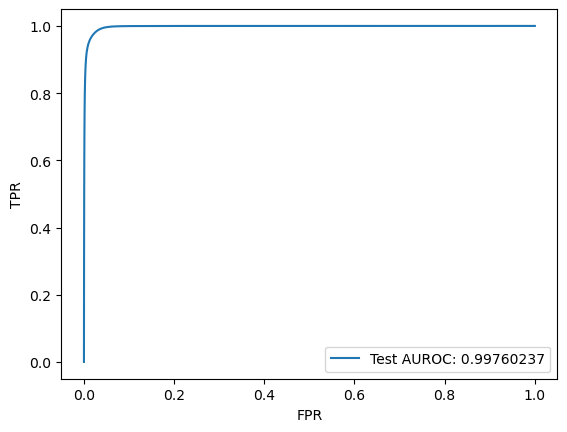

In [35]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(labels, preds, pos_label=1)
auc_test = sklearn.metrics.auc(fpr, tpr)
print(f'Test AUROC: {auc_test:0.8f}')

plt.plot(fpr, tpr, label=f'Test AUROC: {auc_test:0.8f}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

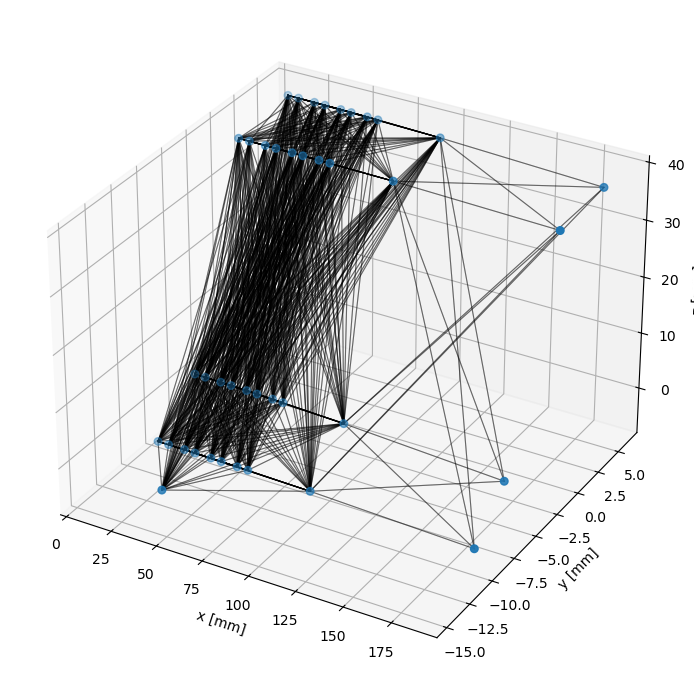

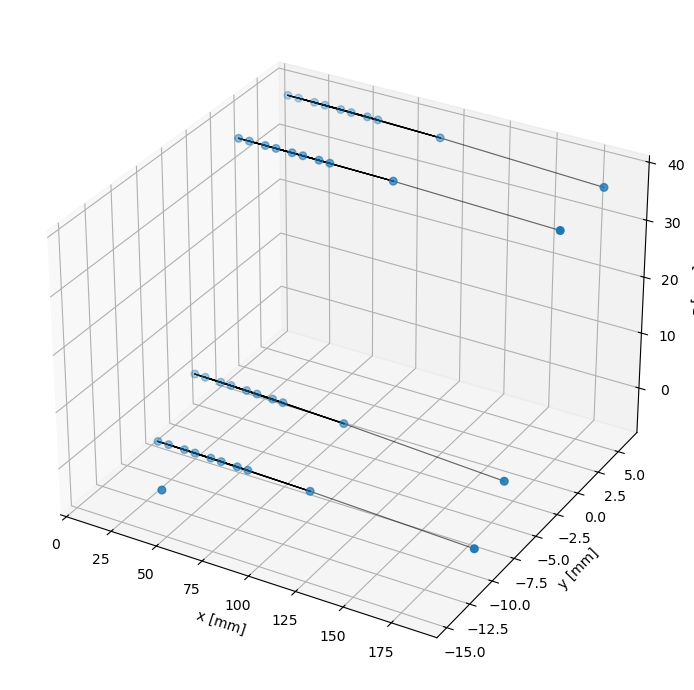

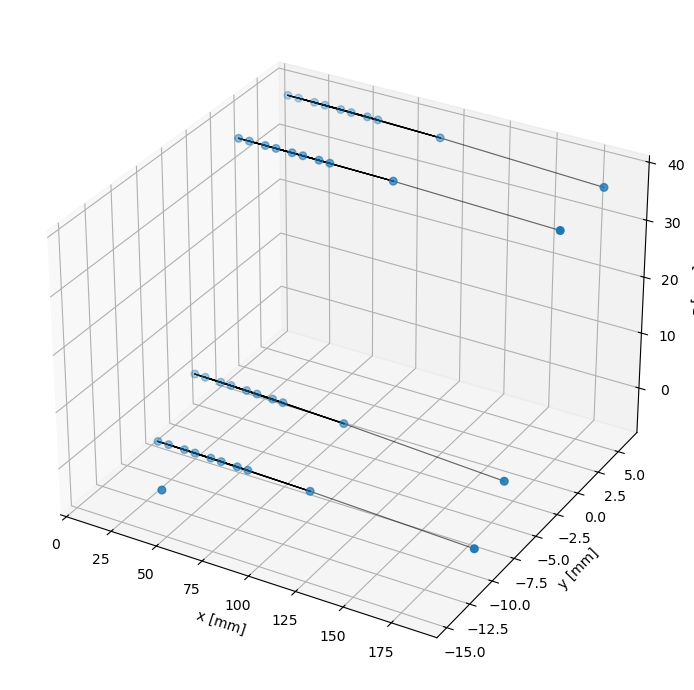

In [36]:
graph = test_dataset[0]
graph

# Analyze graph with model
model.eval()
data = graph.to(device)
output = model(data.x, data.Edep, data.edge_index, data.edge_attr).squeeze(1).detach().cpu()
graph.pred = output>0.5


GTT.plot_pyg_graph_3d(data, plot_truth=True, plot_pred=True)

In [37]:
min_nodes = 4
thres = 0.5

GNN_tracks = 0
Truth_tracks = 0
GNN_track_hits = []
Truth_track_hits = []

matched_tracks = 0
fracs_contained = []

# Check how many parameters the model's forward method takes
# If it's 4, the model take Edep as input feature
Nparams = len(inspect.signature(model.forward).parameters)

model.eval()
with torch.no_grad():
    for batch_idx, data in enumerate(test_loader):

        # Move datat to device 
        data = data.to(device)


        # GNN inference
        if Nparams == 4:
            output = model(data.x, data.Edep, data.edge_index, data.edge_attr)
        else:
            output = model(data.x, data.edge_index, data.edge_attr)

        # Use GNN prediction to create track candidates
        y_pred = output.squeeze()>thres
        data.edge_index = data.edge_index[:,y_pred]
        tracks = data.connected_components()

        # Keep only tracks passing min_nodes requirement
        rm_idx = []
        for index, track in enumerate(tracks):
            if track.x.shape[0] <  min_nodes:
                rm_idx += [index]
        for i in sorted(rm_idx, reverse=True):
            del tracks[i]

        # Get truth tracks
        truth_tracks = []
        for batch_ID in torch.unique(data.batch):
            for track_ID in np.arange(n_primaries)+1:
                track_filter = (data.batch==batch_ID)*(data.truth_ID==track_ID)
                truth_tracks += [data.x[track_filter]]


        GNN_tracks += len(tracks)
        Truth_tracks += len(truth_tracks)
        GNN_track_hits += [track.x.shape[0] for track in tracks]
        Truth_track_hits += [track.shape[0] for track in truth_tracks]


        for truth_track in truth_tracks:
            for index, track in enumerate(tracks):

                # Find fraction of the GNN track that is contained in the truth track
                matches = (track.x[:, None, :] == truth_track[None, :, :]).all(dim=2).any(dim=1)
                count = matches.sum().item()
                frac_contained = count/track.x.shape[0]

                # If we find a matching GNN track, record relevant data, remove GNN track from list, and break
                # A track is matching if over 75% of the GNN track as contained in the truth track
                if frac_contained >= 0.75:
                    # Find fraction of hits not present in truth track
                    matched_tracks += 1
                    fracs_contained += [frac_contained]
                    del tracks[index]
                    break

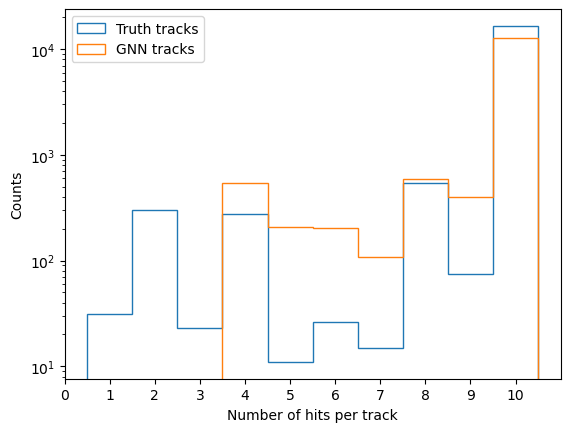

In [42]:
plt.hist(Truth_track_hits, bins=np.arange(0, 10+0.5,1)+0.5, histtype= 'step' , label='Truth tracks')
plt.hist(GNN_track_hits, bins=np.arange(0, 10+0.5,1)+0.5, histtype= 'step' , label='GNN tracks')
plt.xlabel('Number of hits per track')
plt.ylabel('Counts')
plt.yscale('log')
plt.xticks(range(0,11))
plt.legend()

In [51]:
# Track efficiency 
matched_tracks/Truth_tracks

0.8570555555555556

In [52]:
# Fake rate
(GNN_tracks-matched_tracks)/Truth_tracks

0.134

Text(0, 0.5, 'No. tracks')

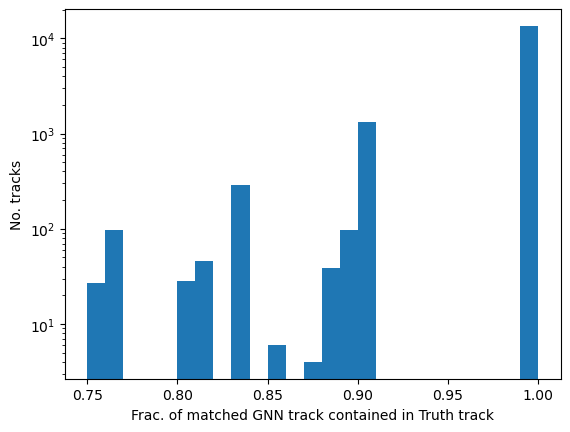

In [49]:
plt.hist(fracs_contained,bins=np.arange(0.75,1.01,0.01))
plt.yscale('log')
plt.xlabel("Frac. of matched GNN track contained in Truth track")
plt.ylabel("No. tracks")